In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification

%matplotlib inline

X, y = make_classification(n_samples=100000, n_features=10, n_redundant=3, n_repeated=2,
                           n_informative=5, n_clusters_per_class=4,
                           random_state=42) #for reproducibility
print(y.shape)

(100000,)


In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [3]:
import tensorflow as tf
from tensorflow import keras as kr
import copy


def build_model():
    data_input = kr.layers.Input(shape=(10,))
    x = kr.layers.Dense(16, activation='relu')(data_input)
    x = kr.layers.Dense(16, activation='relu')(x)
    output = kr.layers.Dense(1, activation='sigmoid')(x)

    model = kr.models.Model(data_input, output)
    sgd = kr.optimizers.SGD(learning_rate=0.01, decay=0, momentum=0.0, nesterov=True)
    model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=['accuracy'])

    return model

def get_parameters(model):
    weights = []
    biases = []
    for layer in model.layers[1:]:
        weights.append(copy.deepcopy(layer.get_weights()[0]))
        biases.append(copy.deepcopy(layer.get_weights()[1]))

    return weights, biases

def set_parameters(model, weights, biases):
    for i in range(len(model.layers)-1):
        model.layers[i+1].set_weights([weights[i], biases[i]])

def get_gradients(model, inputs, outputs):
    """ Gets gradient of model for given inputs and outputs for all weights"""
    grads = model.optimizer.get_gradients(model.total_loss, model.trainable_weights)
    symb_inputs = (model._feed_inputs + model._feed_targets + model._feed_sample_weights)
    f = kr.backend.function(symb_inputs, grads)
    x, y, sample_weight = model._standardize_user_data(inputs, outputs)
    output_grad = f(x + y + sample_weight)

    w_grad = [w for i,w in enumerate(output_grad) if i%2==0]
    b_grad = [w for i,w in enumerate(output_grad) if i%2==1]

    return w_grad, b_grad

def get_updates(model, inputs, outputs, batch_size, epochs):
    w, b = get_parameters(model)
    #model.train_on_batch(inputs, outputs)
    model.fit(inputs, outputs, batch_size=batch_size, epochs=epochs, verbose=0)
    w_new, b_new = get_parameters(model)
    weight_updates = [old - new for old,new in zip(w, w_new)]
    bias_updates = [old - new for old,new in zip(b, b_new)]

    return weight_updates, bias_updates

def apply_updates(model, eta, w_new, b_new):
    w, b = get_parameters(model)
    new_weights = [theta - eta*delta for theta,delta in zip(w, w_new)]
    new_biases = [theta - eta*delta for theta,delta in zip(b, b_new)]
    set_parameters(model, new_weights, new_biases)

def aggregate(n_layers, n_peers, f, w_updates, b_updates):
    agg_w = [f([w_updates[j][i] for j in range(n_peers)], axis=0) for i in range(n_layers)]
    agg_b = [f([b_updates[j][i] for j in range(n_peers)], axis=0) for i in range(n_layers)]
    return agg_w, agg_b

def plot_updates(W, B):
    plt.figure(figsize=(16,6))
    h = W[0].reshape(-1)
    for w in W[1:]:
        h = np.append(h, w.reshape(-1))
    plt.subplot(121)
    plt.hist(h, bins=50)
    h = B[0].reshape(-1)
    for b in B[1:]:
        h = np.append(h, b.reshape(-1))
    plt.subplot(122)
    plt.hist(h, bins=50)
    plt.show()
    plt.close()

def plot_model(W,B):
    rows = 1
    cols = len(W)*2
    i = 1
    plt.figure(figsize=(16,3))
    for w,b in zip(W,B):
        plt.subplot(rows,cols,i)
        plt.imshow(w, cmap='Blues')
        plt.tick_params(
            which='both',
            top=False,bottom=False,left=False,right=False,
            labeltop=False,labelbottom=False,labelleft=False,labelright=False)
        i+=1
        plt.subplot(rows,cols,i)
        plt.imshow(b.reshape(-1,1), cmap='Blues')
        plt.tick_params(
            which='both',
            top=False,bottom=False,left=False,right=False,
            labeltop=False,labelbottom=False,labelleft=False,labelright=False)
        i+=1
    plt.show()
    plt.close()

In [4]:
n_peers = 10
n_rounds = 10

global_model = build_model()
n_layers = len(global_model.layers)-1

network = []
for i in range(n_peers):
    network.append(build_model())

for t in range(n_rounds):
    print(f'Round {t}.')

    global_weights, global_biases = get_parameters(global_model)
    print('Global model')
    plot_model(global_weights, global_biases)
    print('Global model parameters distribution:')
    plot_updates(global_weights, global_biases)

    network_weight_updates = []
    network_bias_updates = []

    i = 0
    for local_model in network:
        set_parameters(local_model, global_weights, global_biases)

        ss = int(len(X_train)/n_peers)
        inputs = X_train[i*ss:i*ss+ss]
        outputs = y_train[i*ss:i*ss+ss]


        local_weight_updates, local_bias_updates = get_updates(local_model, inputs, outputs, 64, 5)
        print(f'Peer {i+1} updates distribution:')
        plot_updates(local_weight_updates, local_bias_updates)

        network_weight_updates.append(local_weight_updates)
        network_bias_updates.append(local_bias_updates)

        i+=1

    aggregated_weights, aggregated_biases = aggregate(n_layers, n_peers, np.mean, network_weight_updates, network_bias_updates)

    apply_updates(global_model, 1, aggregated_weights, aggregated_biases)

    score = global_model.evaluate(X_test, y_test, verbose=0)
    print(f'Global model loss: {score[0]}; global model accuracy: {score[1]}')



/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Round 0.
Peer 1 updates distribution:
Peer 2 updates distribution:
Peer 3 updates distribution:
Peer 4 updates distribution:
Peer 5 updates distribution:
Peer 6 updates distribution:
Peer 7 updates distribution:
Peer 8 updates distribution:
Peer 9 updates distribution:
Peer 10 updates distribution:
Global model loss: 0.4913676679134369; global model accuracy: 0.768969714641571
Round 1.
Peer 1 updates distribution:
Peer 2 updates distribution:
Peer 3 updates distribution:
Peer 4 updates distribution:
Peer 5 updates distribution:
Peer 6 updates distribution:
Peer 7 updates distribution:
Peer 8 updates distribution:
Peer 9 updates distribution:
Peer 10 updates distribution:
Global model loss: 0.4475756585597992; global model accuracy: 0.79178786277771
Round 2.
Peer 1 updates distribution:
Peer 2 updates distribution:
Peer 3 updates distribution:
Peer 4 updates distribution:
Peer 5 updates distribution:
Peer 6 updates distribution:
Peer 7 updates distribution:
Peer 8 updates distribution:


Round 0.
Global model


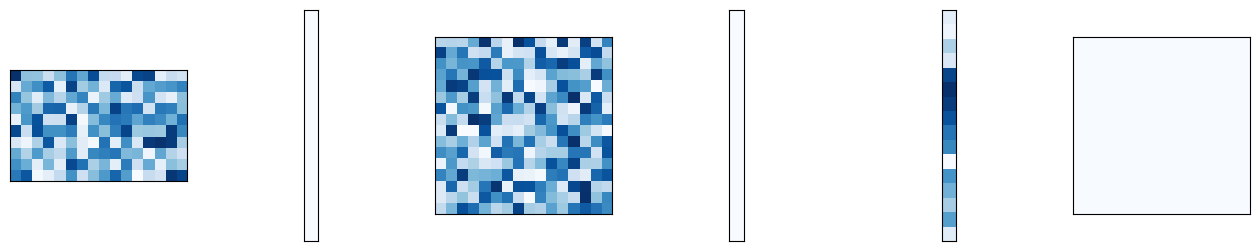

Global model parameters distribution:


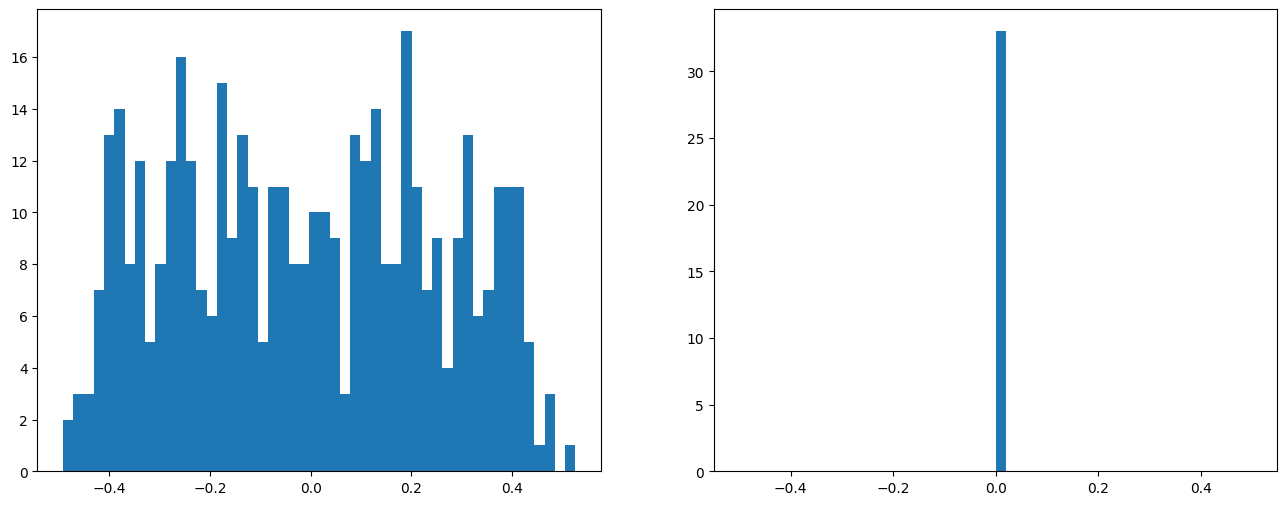

Peer 1 updates distribution:


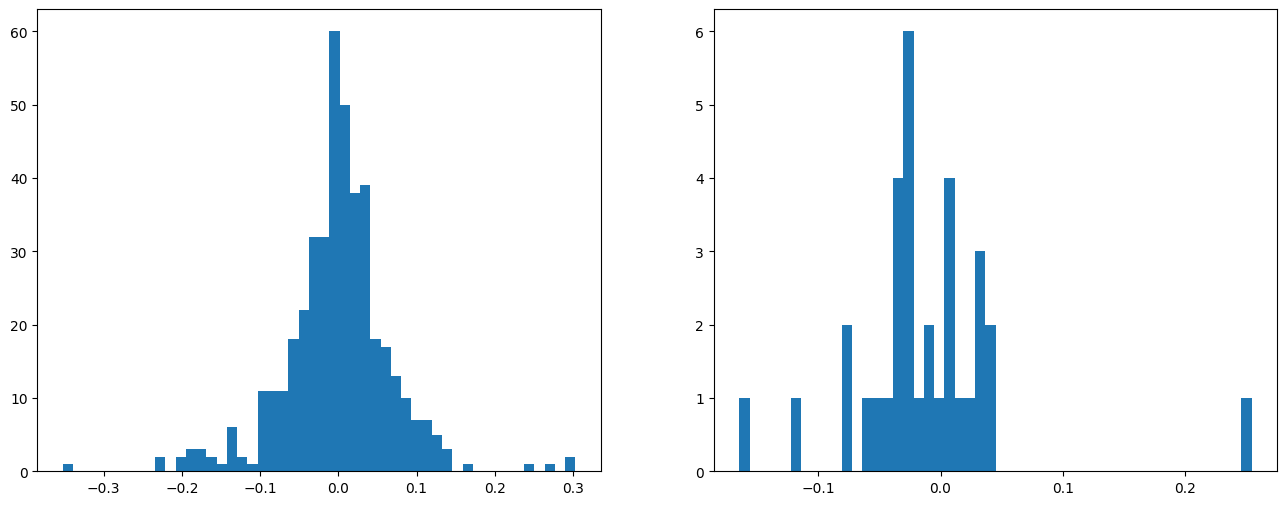

Peer 2 updates distribution:


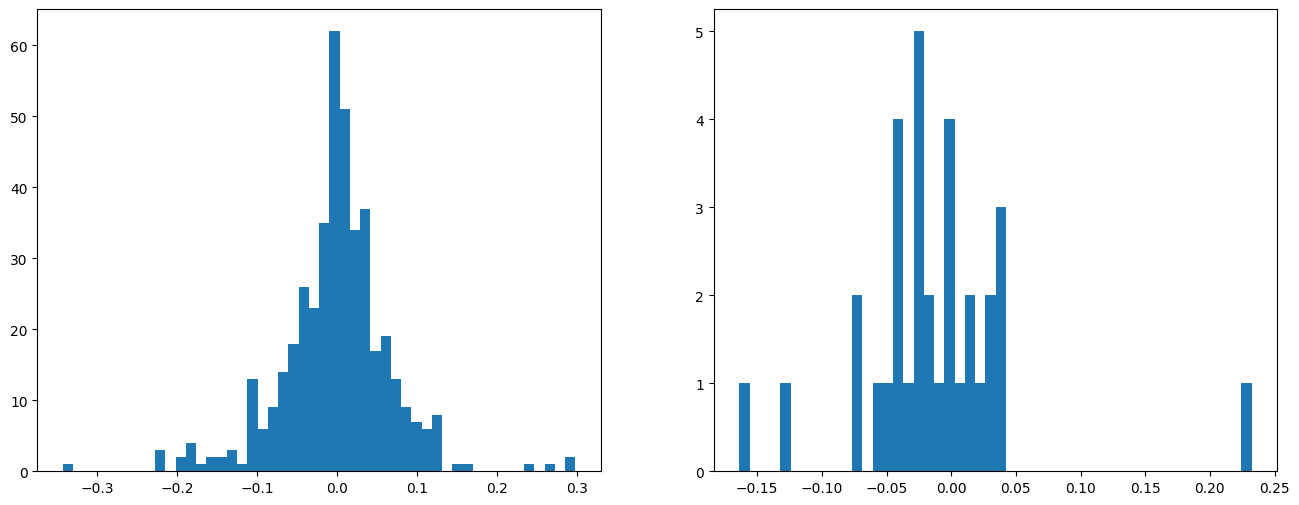

Peer 3 updates distribution:


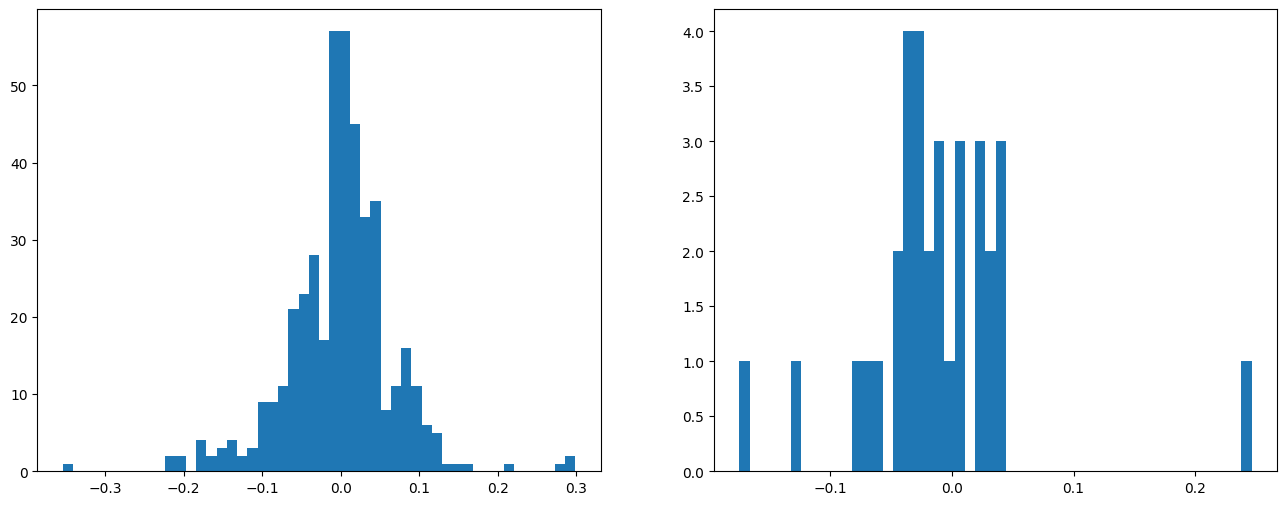

Peer 4 updates distribution:


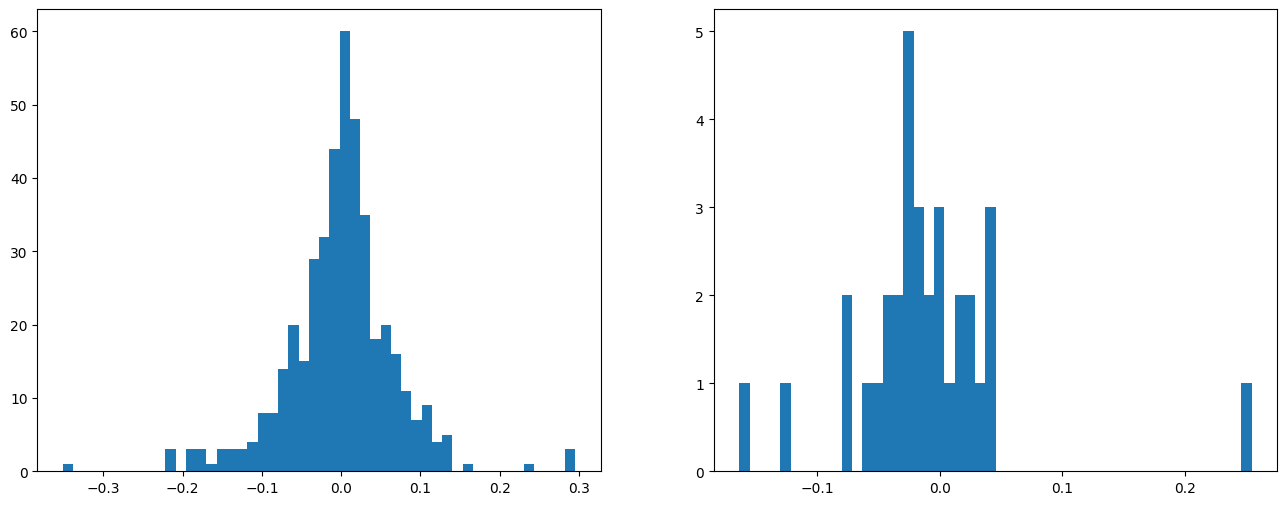

Peer 5 updates distribution:


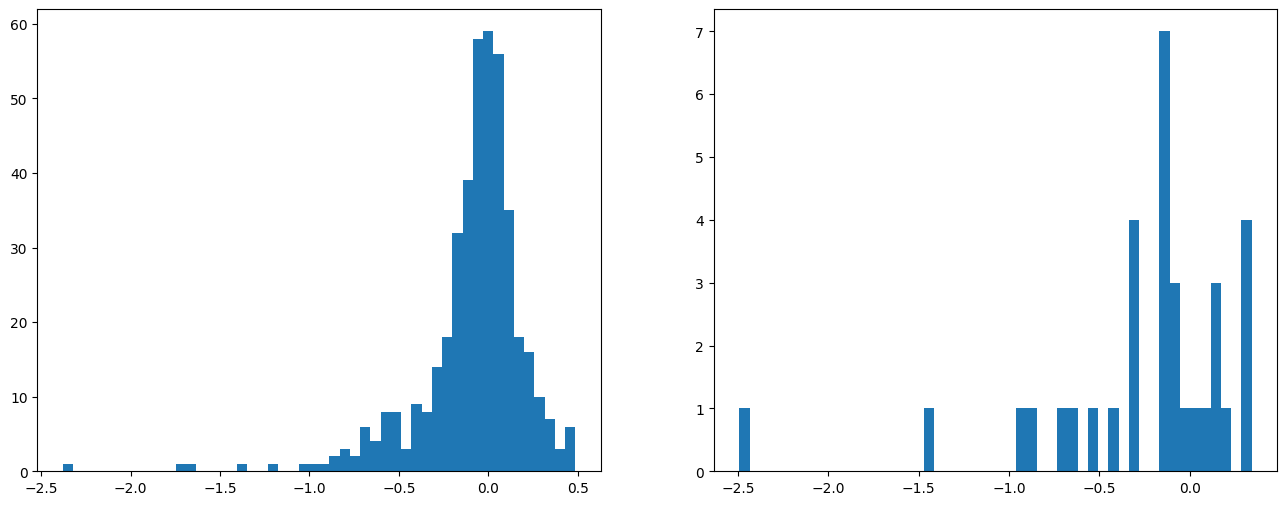

Aggregated updates distribution:


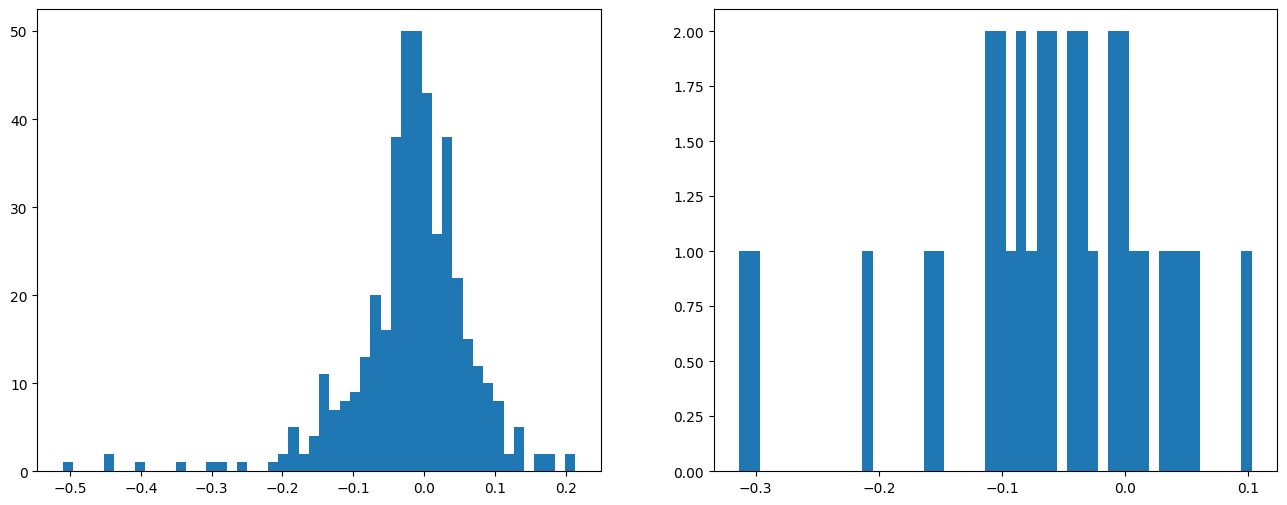

Global model loss: 2.975778102874756; global model accuracy: 0.5007575750350952
Round 1.
Global model


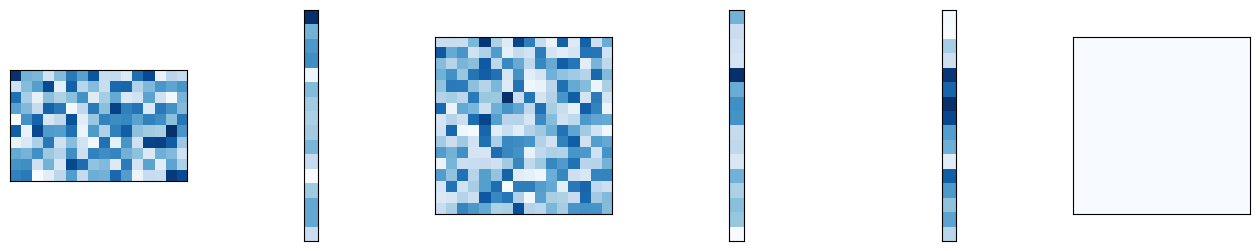

Global model parameters distribution:


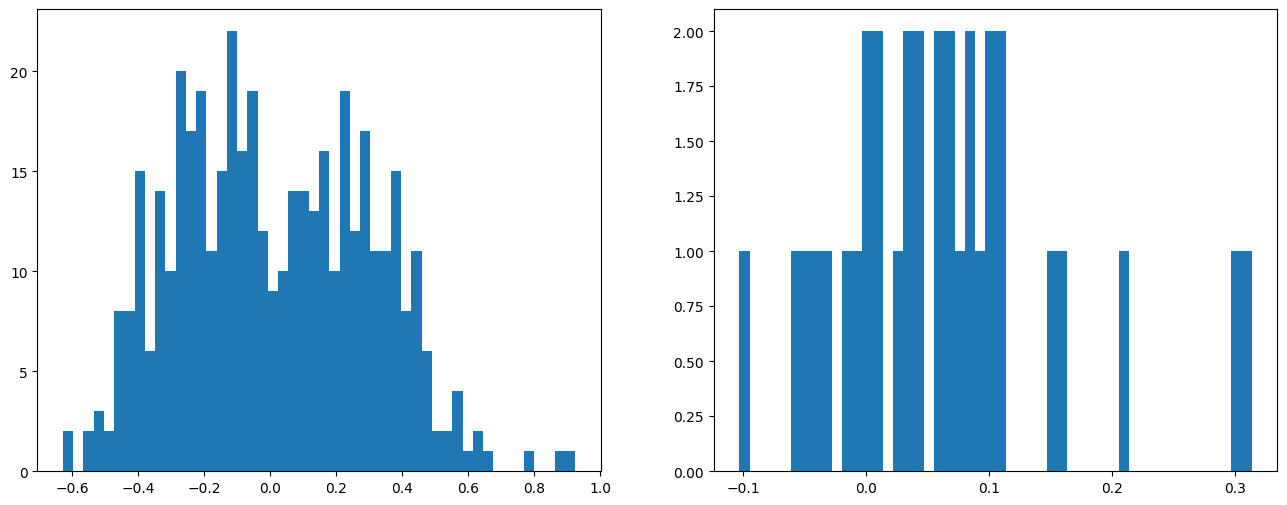

Peer 1 updates distribution:


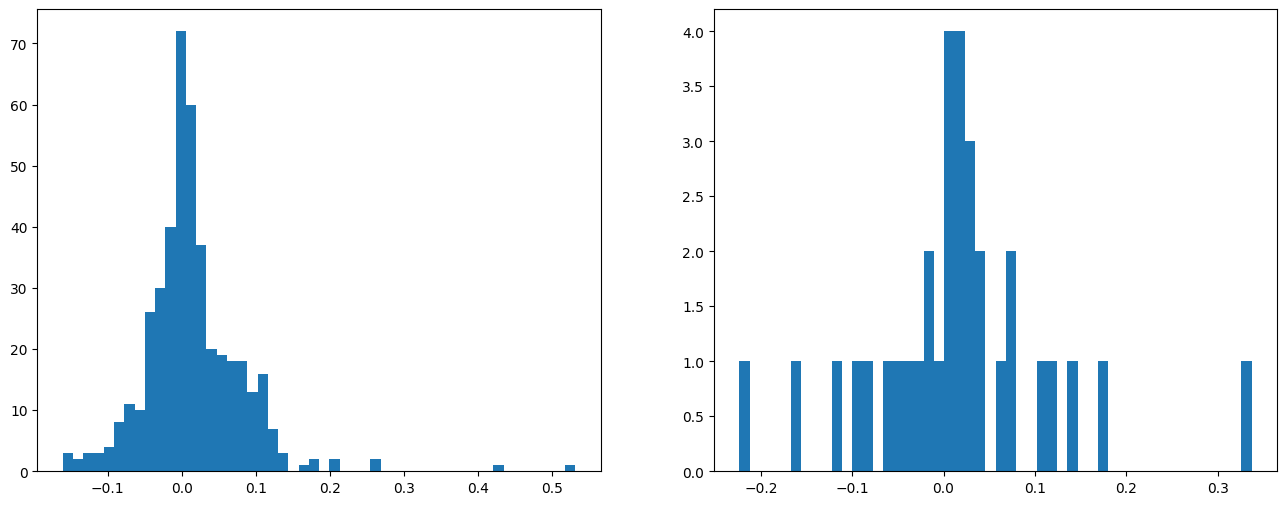

Peer 2 updates distribution:


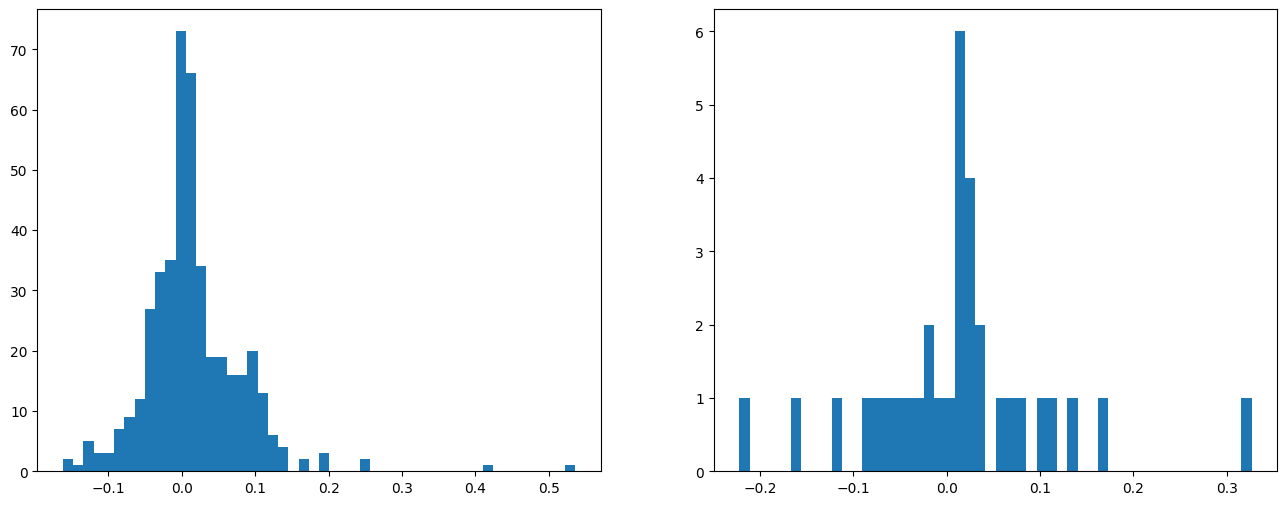

Peer 3 updates distribution:


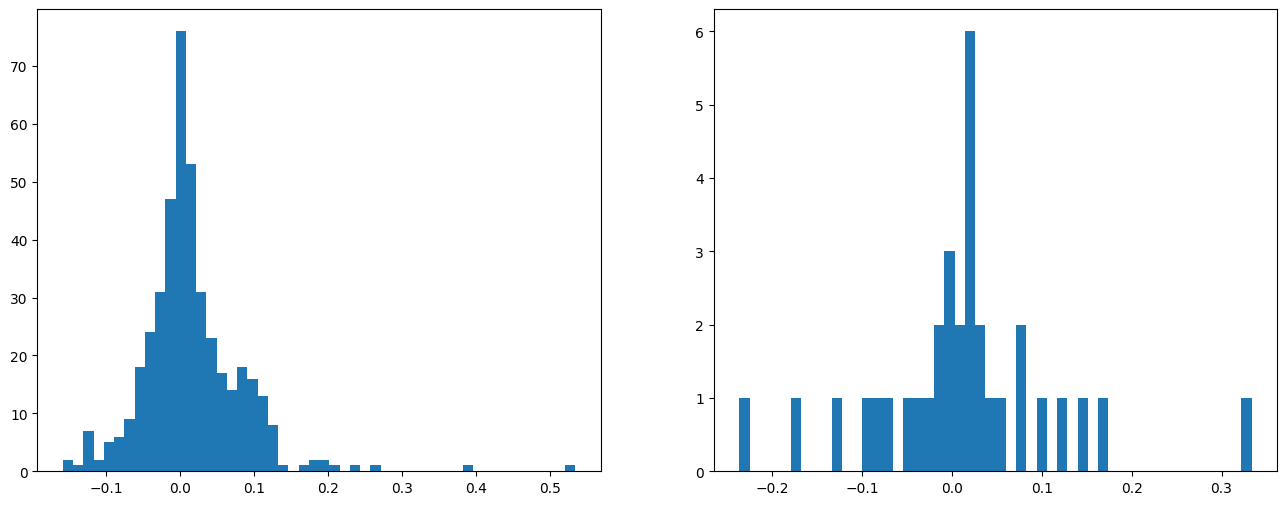

Peer 4 updates distribution:


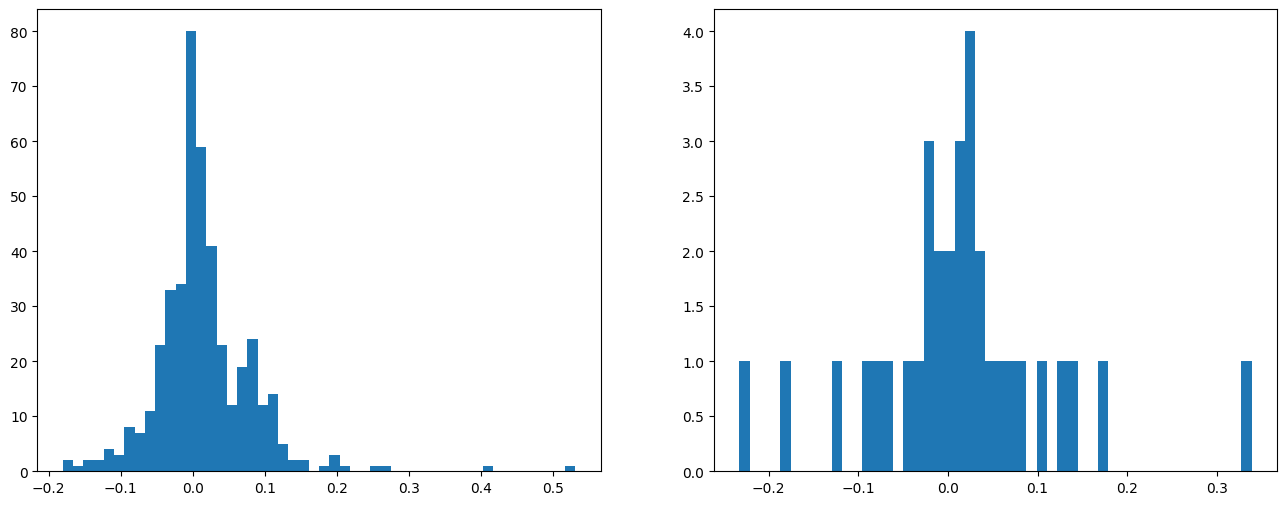

Peer 5 updates distribution:


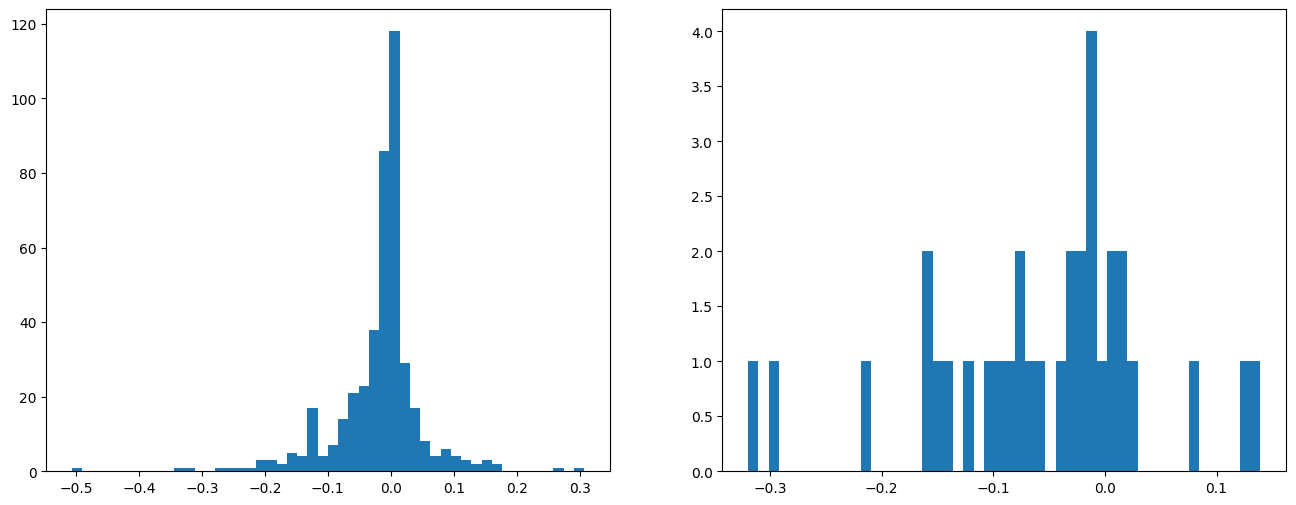

Aggregated updates distribution:


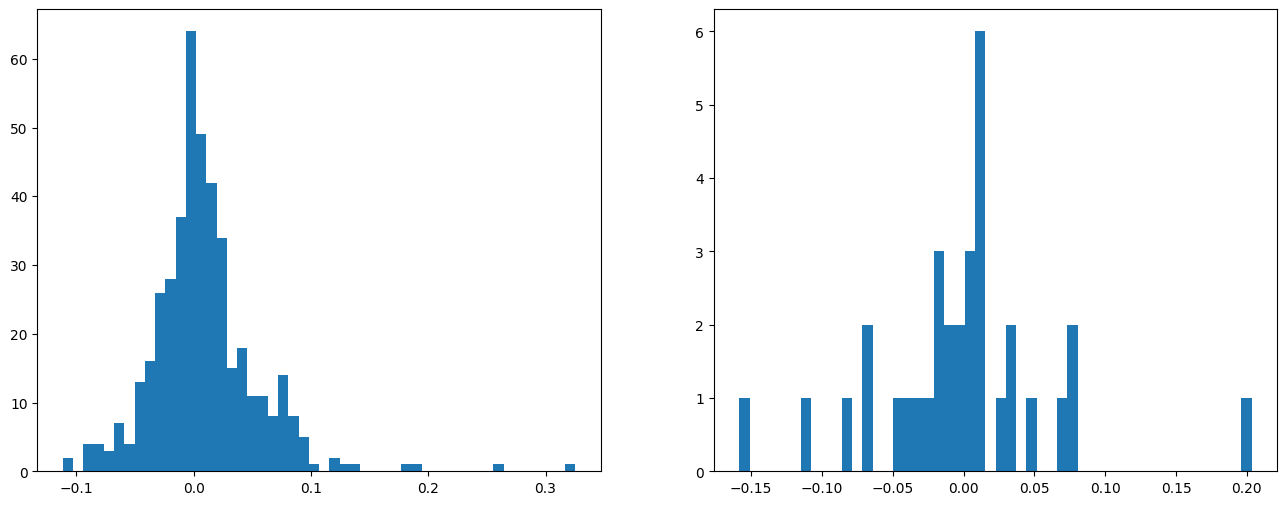

Global model loss: 0.8598668575286865; global model accuracy: 0.6041818261146545
Round 2.
Global model


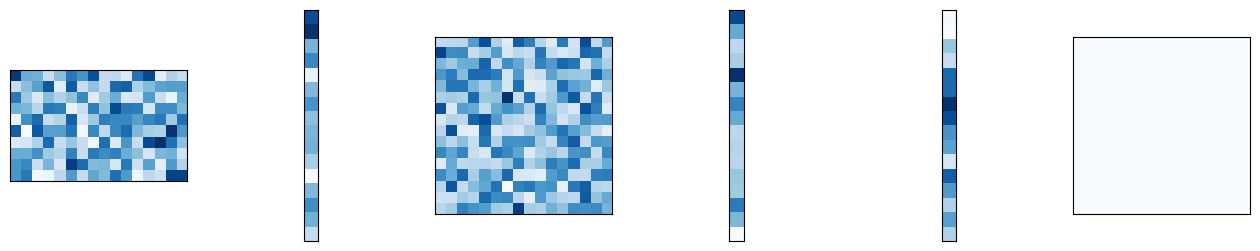

Global model parameters distribution:


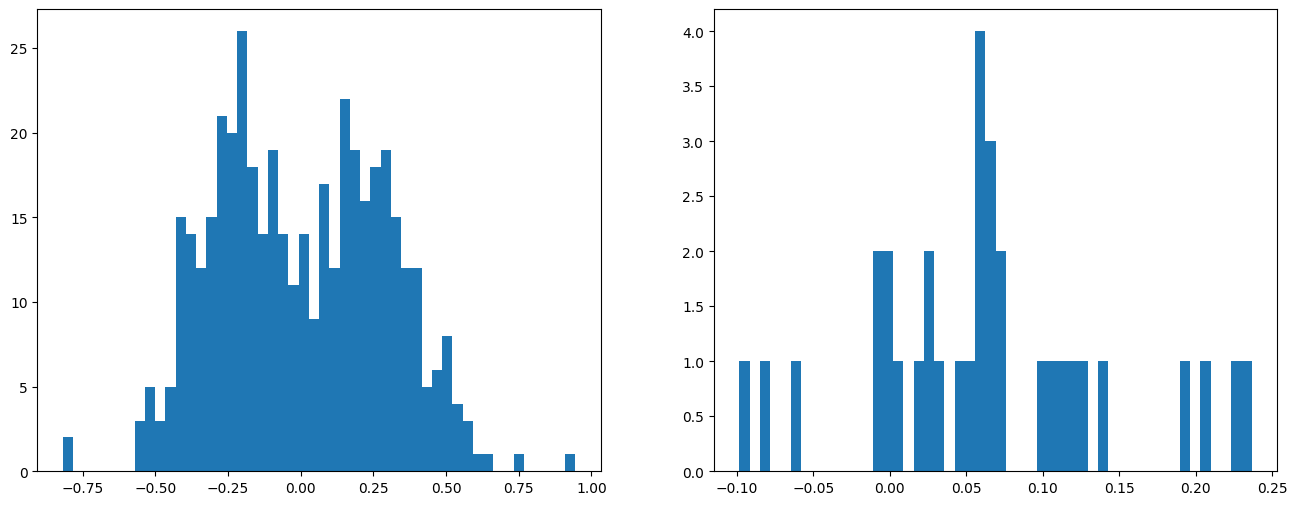

Peer 1 updates distribution:


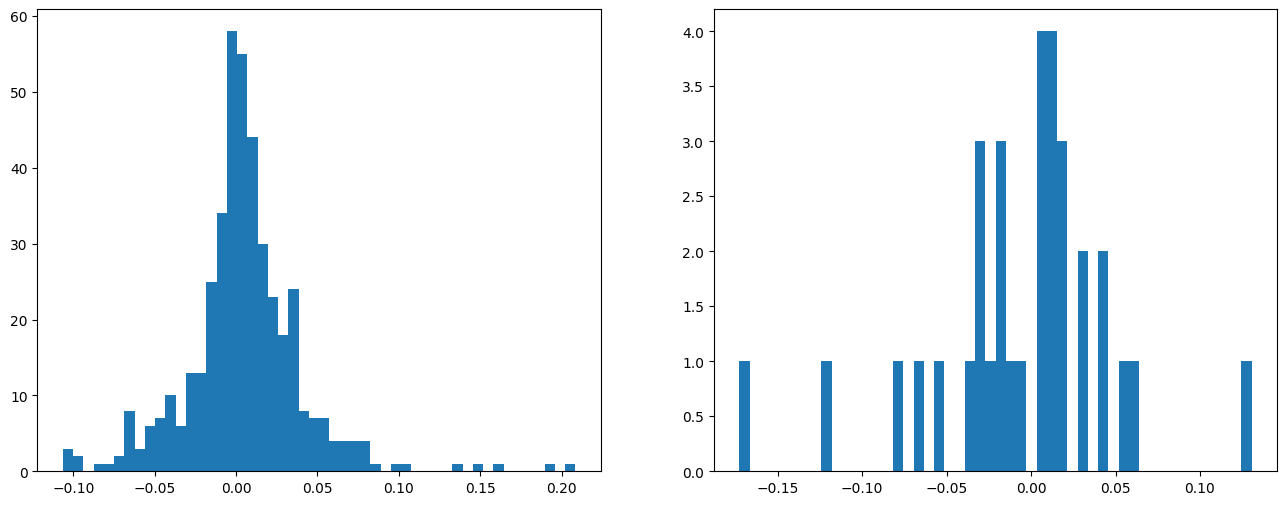

Peer 2 updates distribution:


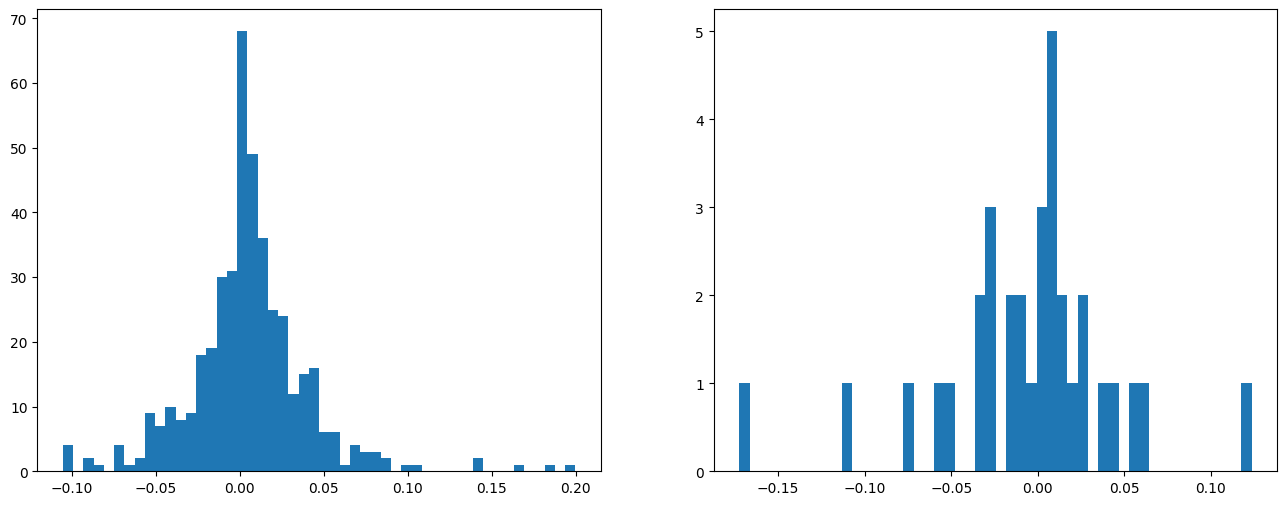

Peer 3 updates distribution:


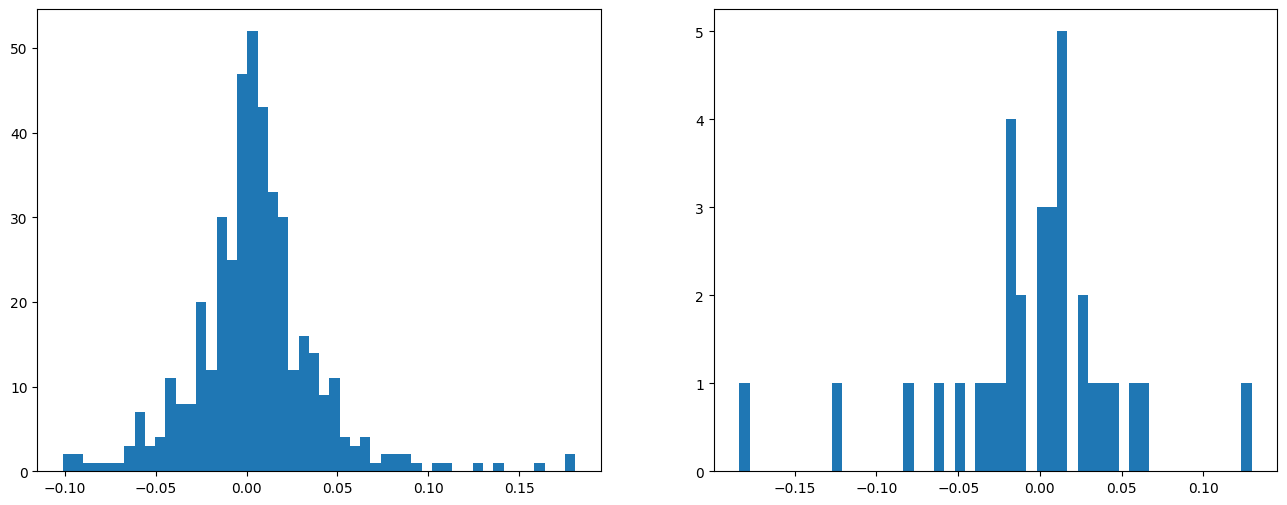

Peer 4 updates distribution:


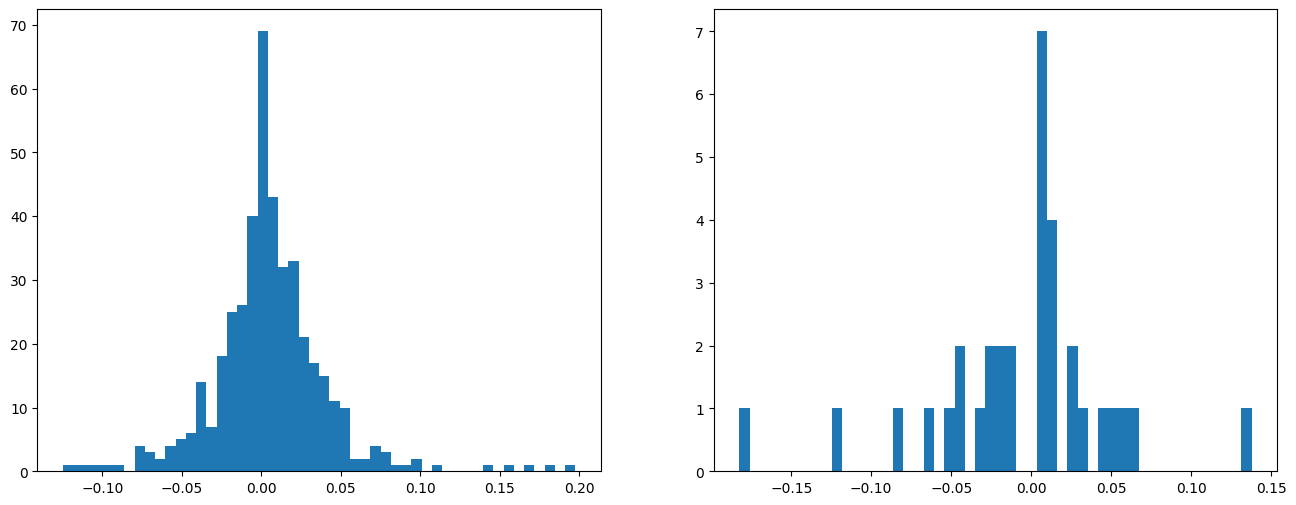

Peer 5 updates distribution:


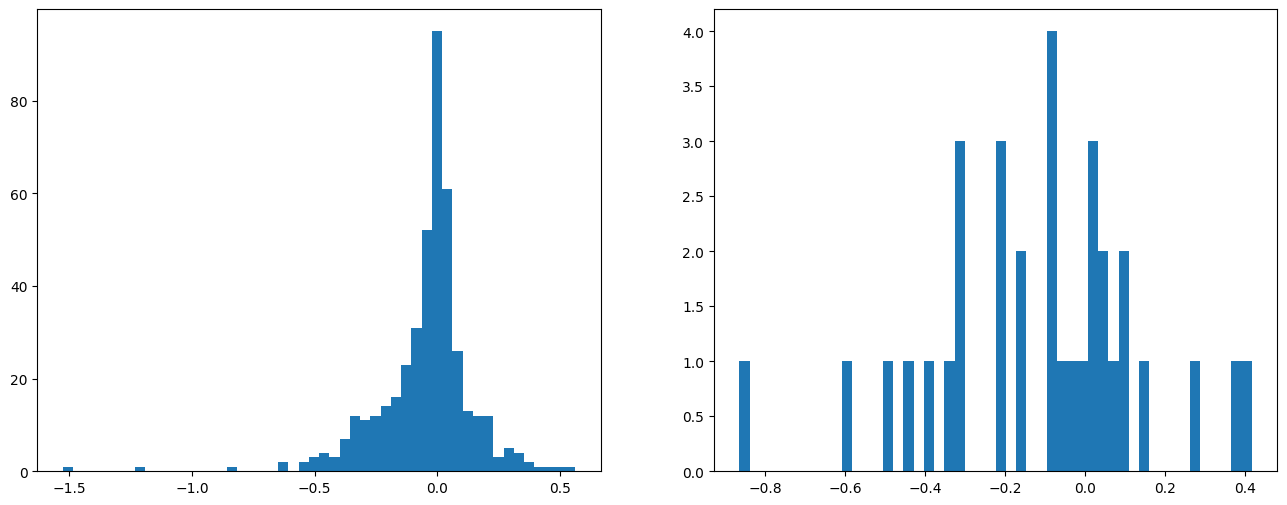

Aggregated updates distribution:


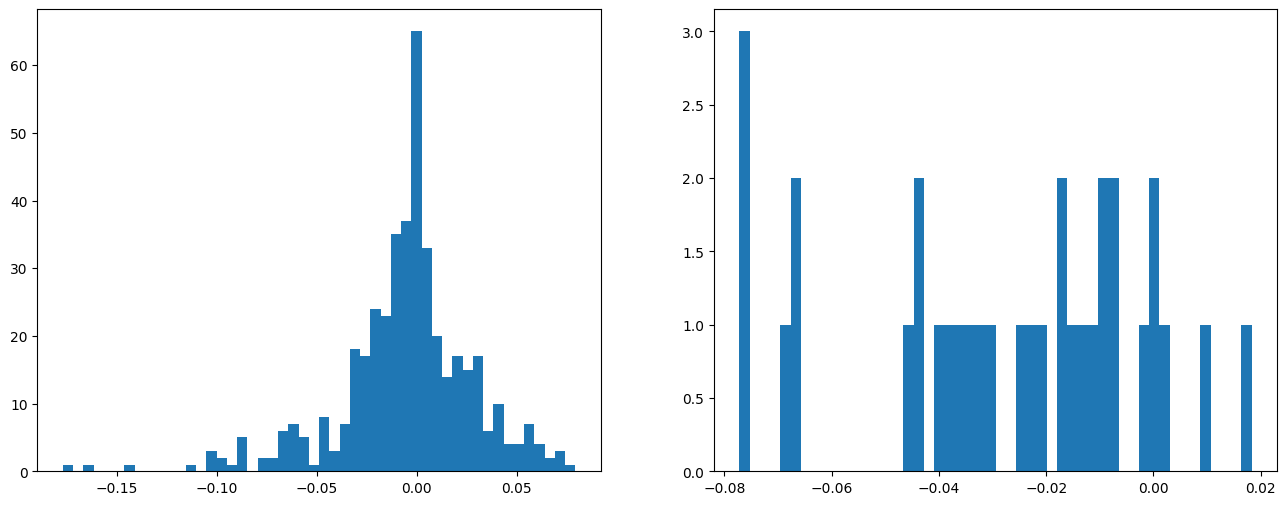

Global model loss: 2.2912917137145996; global model accuracy: 0.5020303130149841
Round 3.
Global model


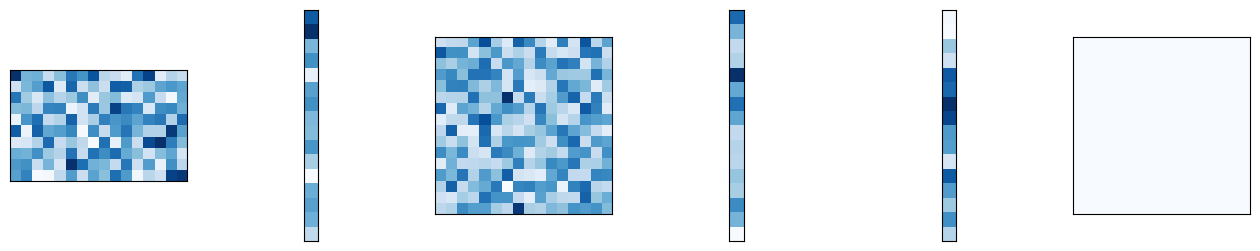

Global model parameters distribution:


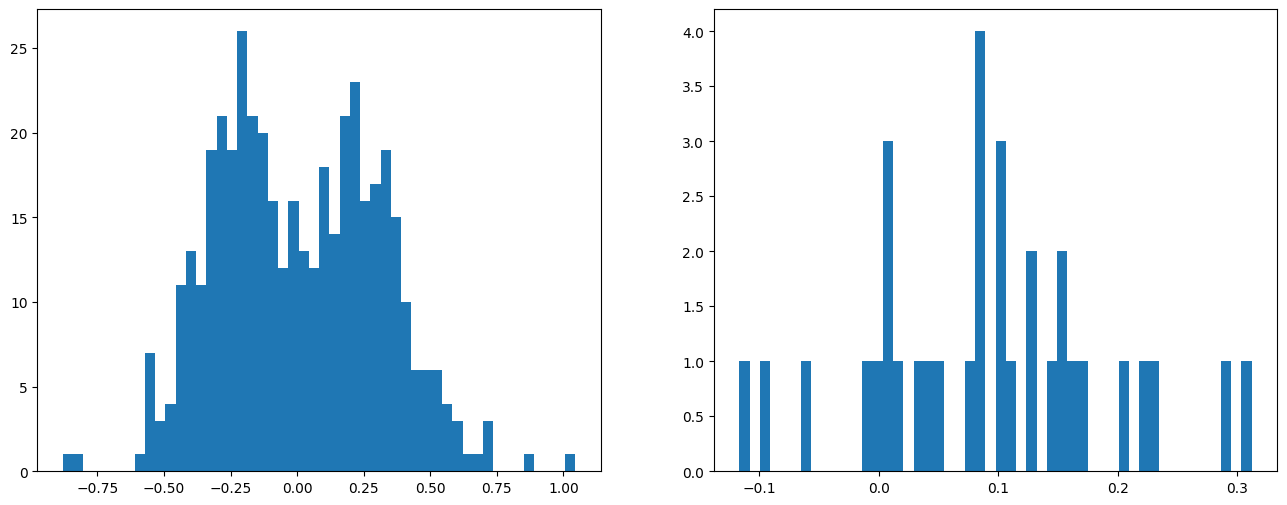

Peer 1 updates distribution:


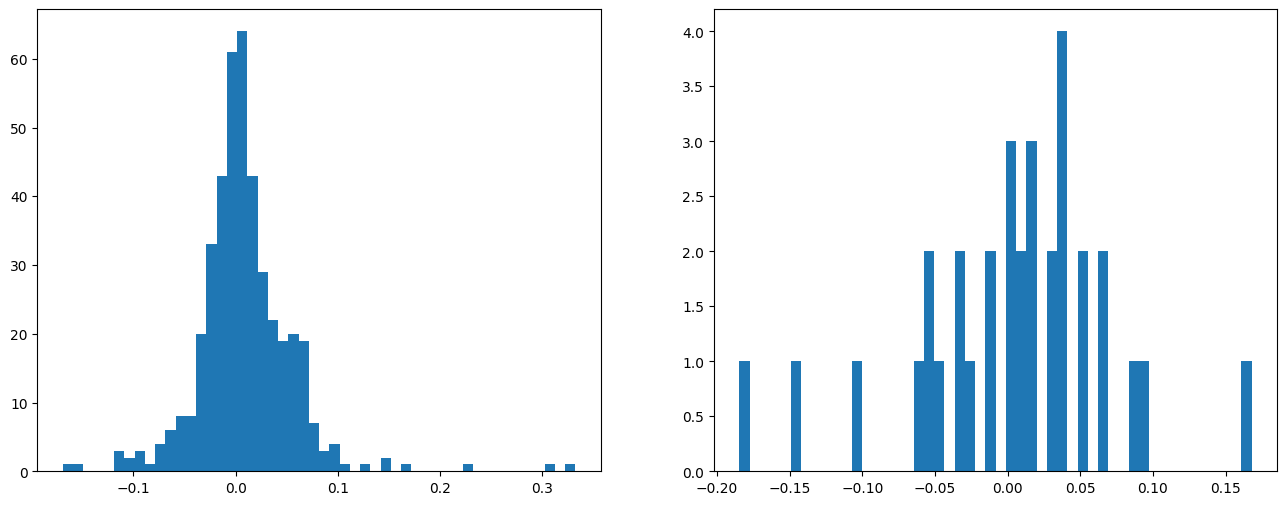

Peer 2 updates distribution:


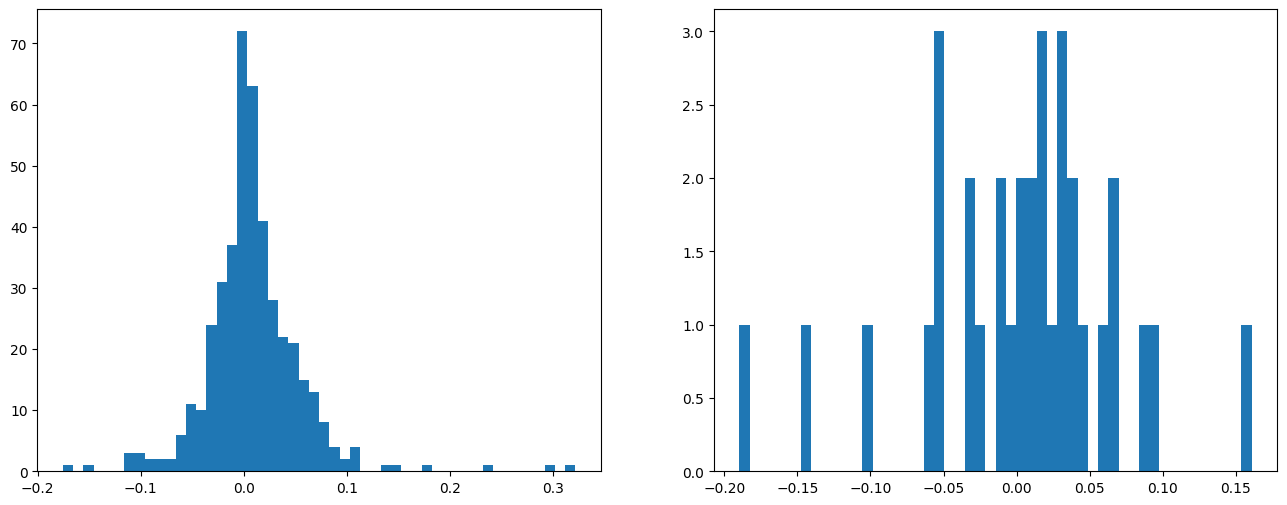

Peer 3 updates distribution:


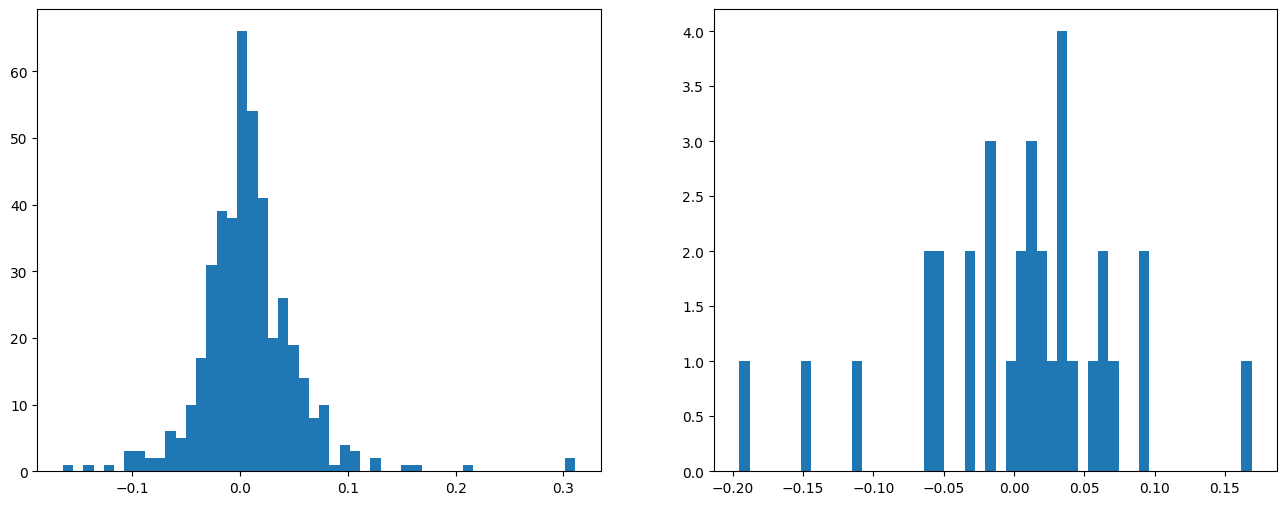

Peer 4 updates distribution:


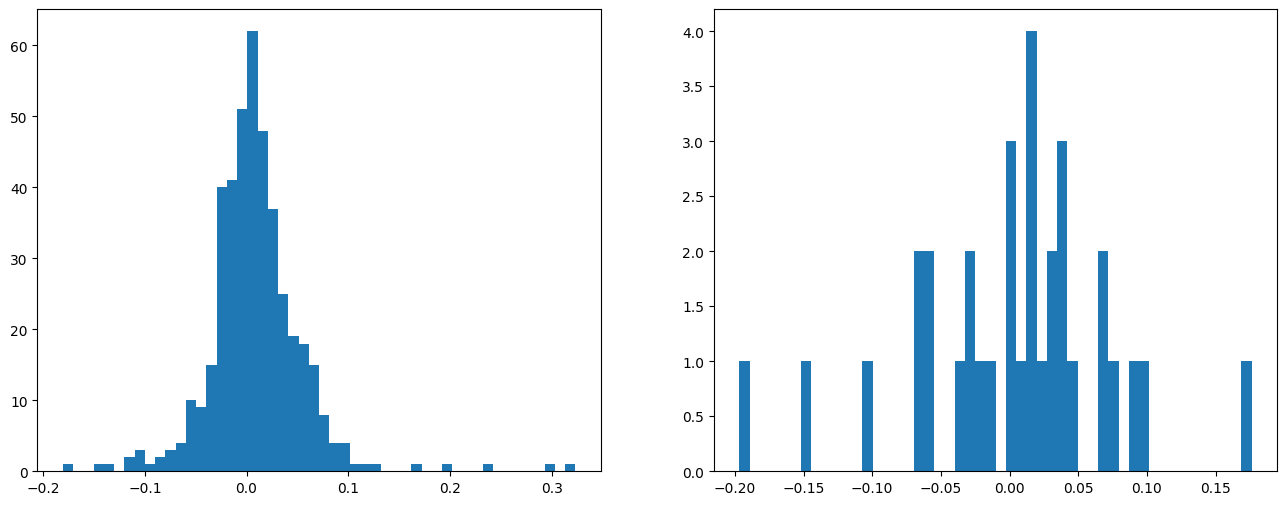

Peer 5 updates distribution:


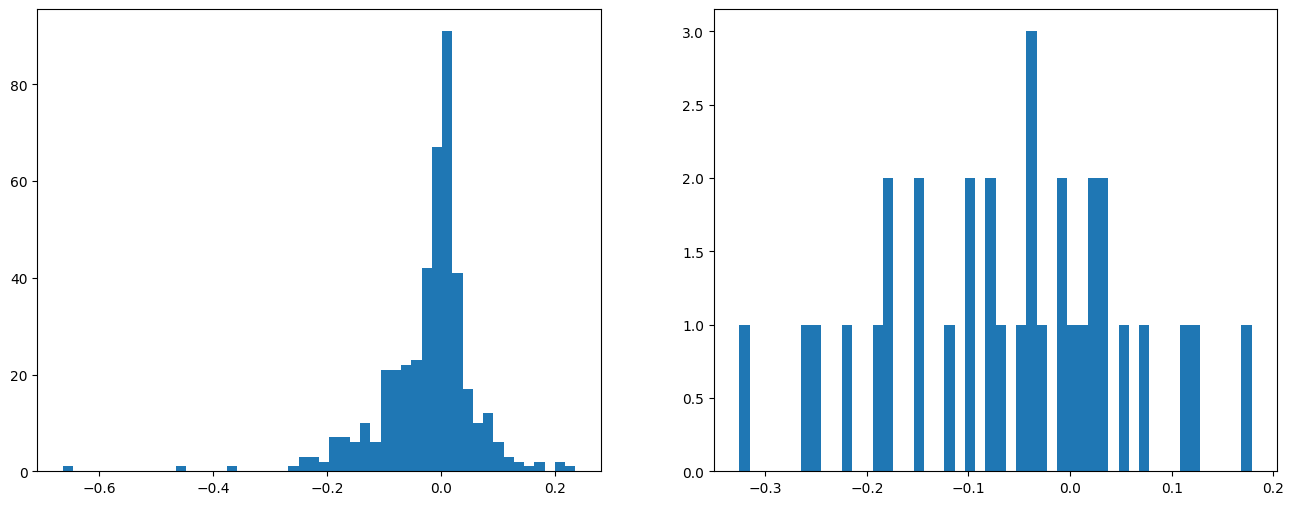

Aggregated updates distribution:


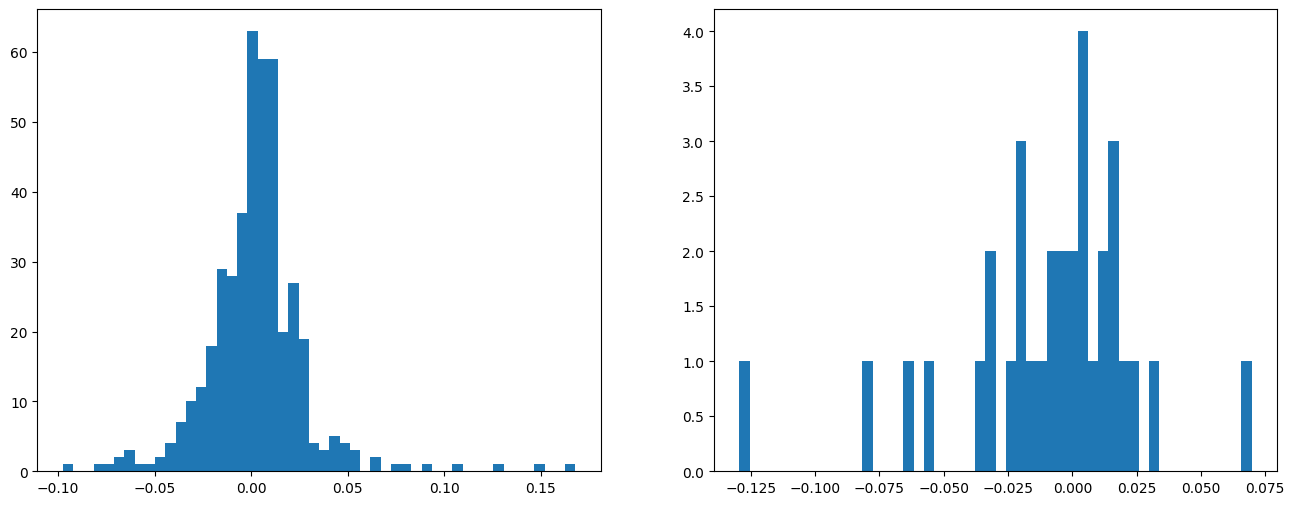

Global model loss: 1.1316558122634888; global model accuracy: 0.5754848718643188
Round 4.
Global model


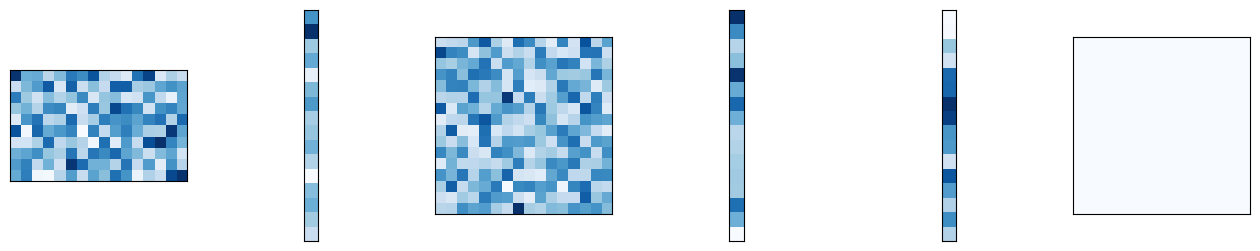

Global model parameters distribution:


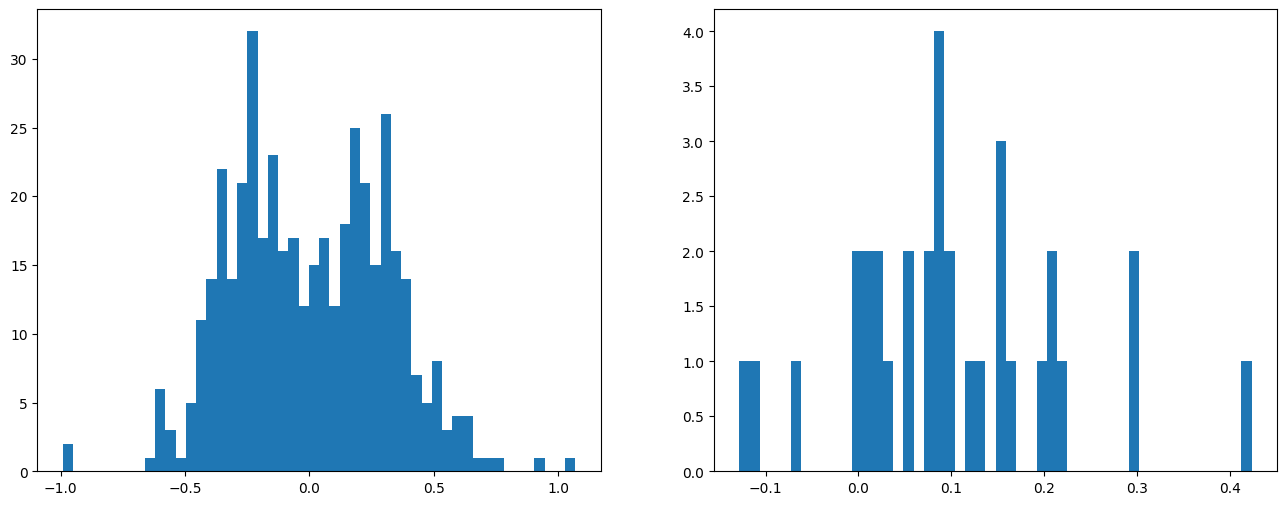

Peer 1 updates distribution:


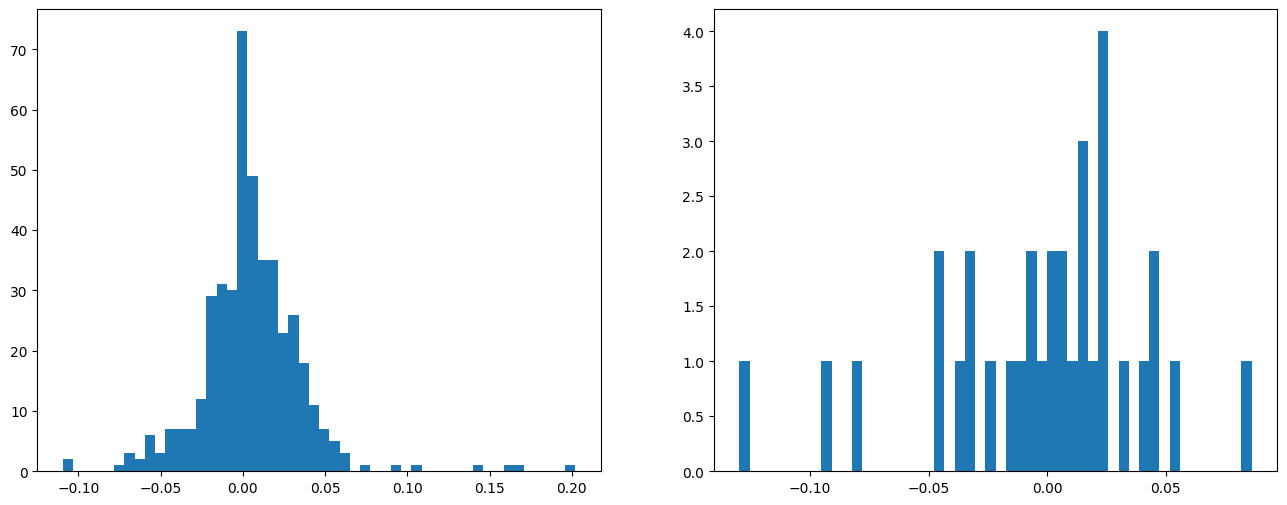

Peer 2 updates distribution:


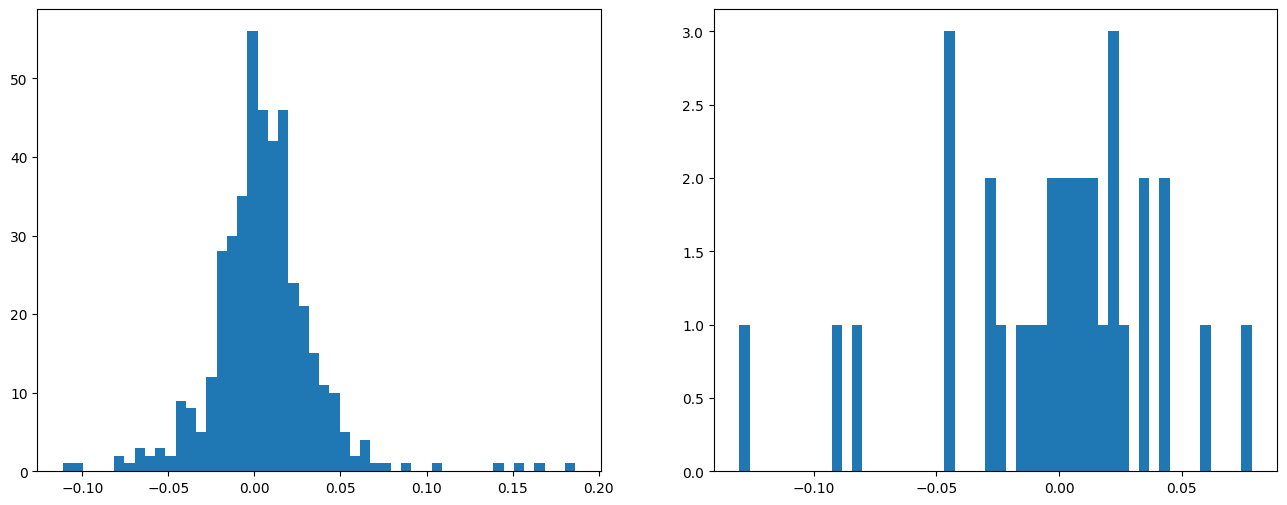

Peer 3 updates distribution:


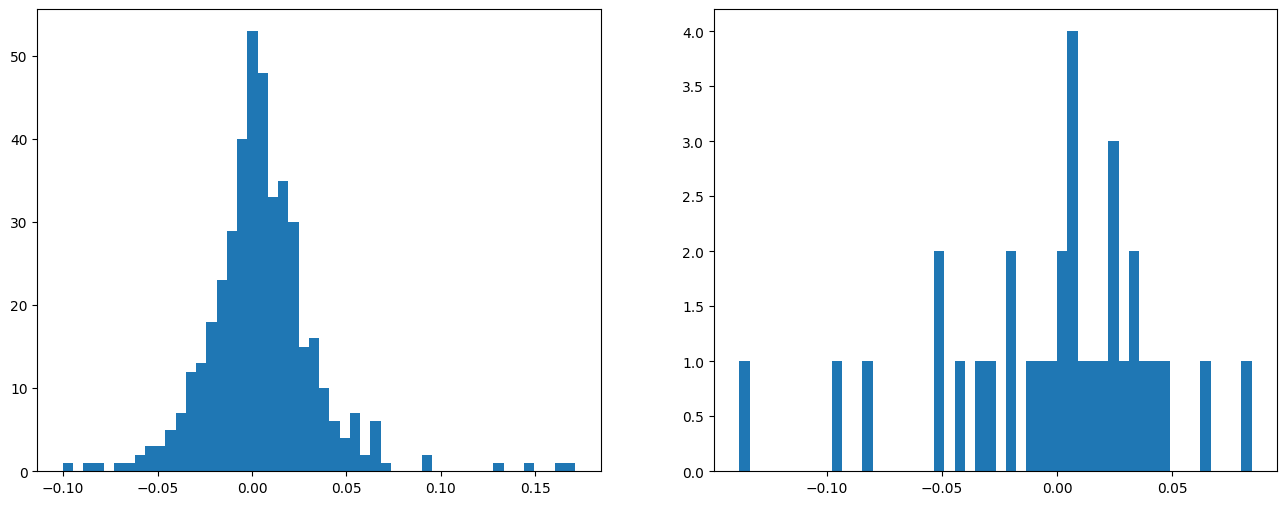

Peer 4 updates distribution:


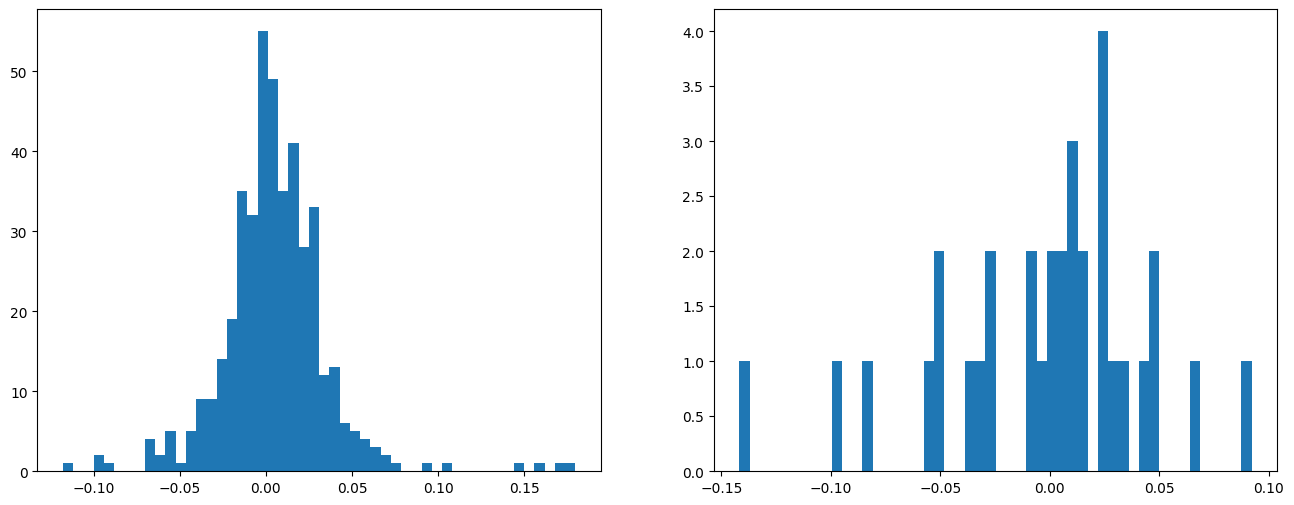

Peer 5 updates distribution:


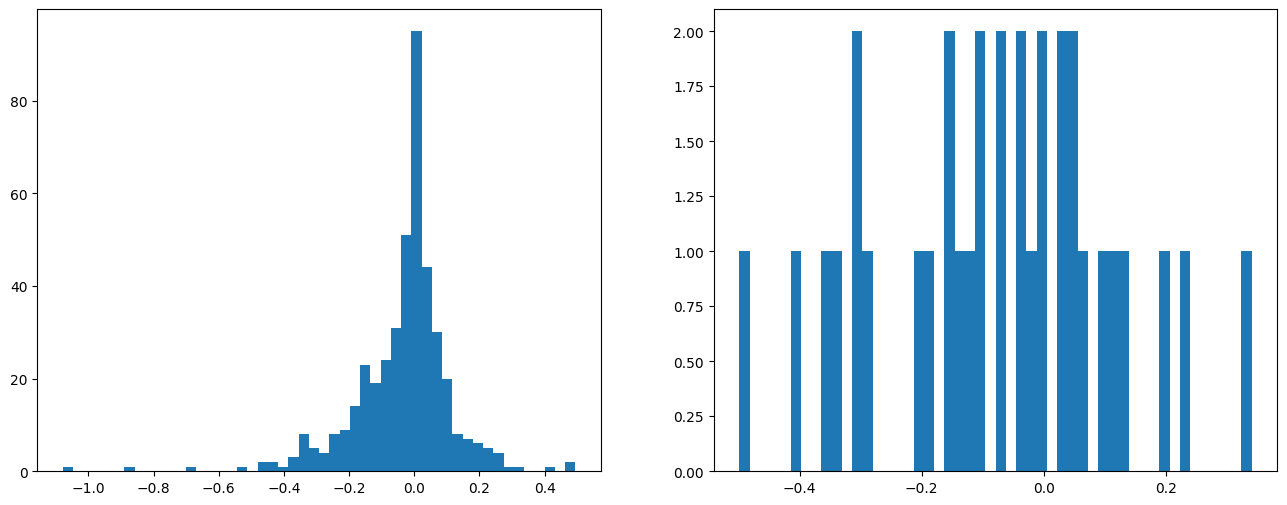

Aggregated updates distribution:


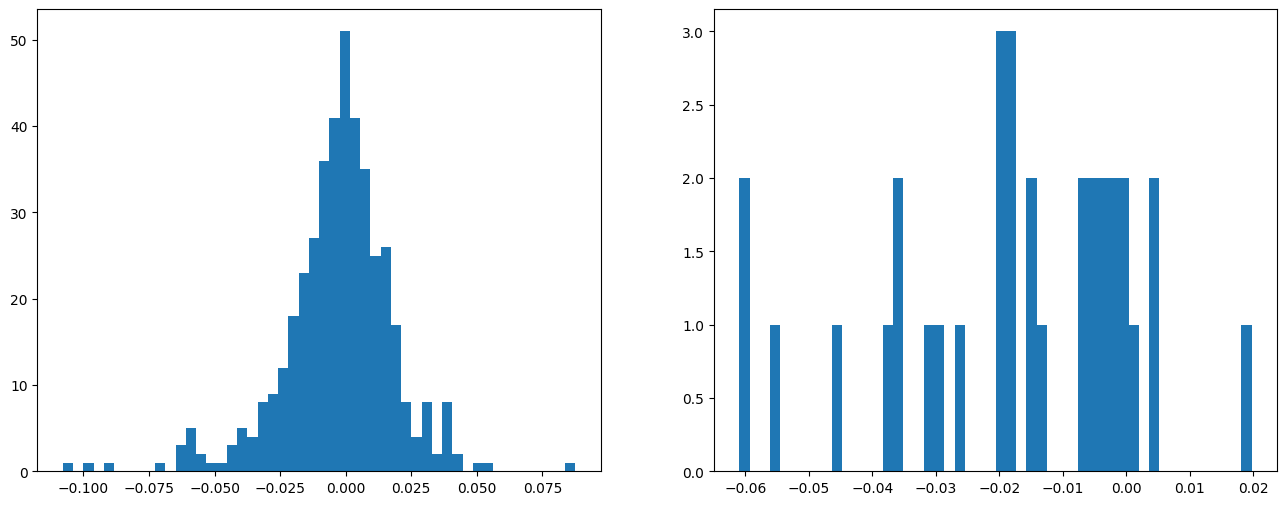

Global model loss: 2.1626648902893066; global model accuracy: 0.5048484802246094


In [ ]:
n_peers = 5
n_rounds = 5

network = []

global_model = build_model()
n_layers = len(global_model.layers)-1

for i in range(n_peers):
    network.append(build_model())

for t in range(n_rounds):
    print(f'Round {t}.')

    global_weights, global_biases = get_parameters(global_model)
    print('Global model')
    plot_model(global_weights, global_biases)
    print('Global model parameters distribution:')
    plot_updates(global_weights, global_biases)

    network_weight_updates = []
    network_bias_updates = []

    # Good peers
    i = 0
    for local_model in network[:-1]:
        set_parameters(local_model, global_weights, global_biases)

        ss = int(len(X_train)/n_peers)
        inputs = X_train[i*ss:i*ss+ss]
        outputs = y_train[i*ss:i*ss+ss]


        local_weight_updates, local_bias_updates = get_updates(local_model, inputs, outputs, 64, 5)
        print(f'Peer {i+1} updates distribution:')
        plot_updates(local_weight_updates, local_bias_updates)

        network_weight_updates.append(local_weight_updates)
        network_bias_updates.append(local_bias_updates)

        i+=1

    # Malicious peer ###########################################################################
    local_model = network[-1]
    set_parameters(local_model, global_weights, global_biases)

    ss = int(len(X_train)/n_peers)
    inputs = X_train[i*ss:i*ss+ss]
    outputs = y_train[i*ss:i*ss+ss]

    # Changes class labels
    outputs = np.ones(shape=(ss,1))

    local_weight_updates, local_bias_updates = get_updates(local_model, inputs, outputs, 64, 5)

    # Boosts own update
    local_weight_updates = [n_peers*w for w in local_weight_updates]
    local_bias_updates = [n_peers*b for b in local_bias_updates]
    print(f'Peer {i+1} updates distribution:')
    plot_updates(local_weight_updates, local_bias_updates)

    network_weight_updates.append(local_weight_updates)
    network_bias_updates.append(local_bias_updates)

    ############################################################################################

    aggregated_weights, aggregated_biases = aggregate(n_layers, n_peers, np.mean, network_weight_updates, network_bias_updates)
    apply_updates(global_model, 1, aggregated_weights, aggregated_biases)
    print('Aggregated updates distribution:')
    plot_updates(aggregated_weights, aggregated_biases)

    score = global_model.evaluate(X_test, y_test, verbose=0)
    print(f'Global model loss: {score[0]}; global model accuracy: {score[1]}')